# Reflection


In the context of LLM agent building, reflection refers to the process of prompting an LLM to observe its past steps (along with potential observations from tools/the environment) to assess the quality of the chosen actions.
This is then used downstream for things like re-planning, search, or evaluation.



This notebook demonstrates a very simple form of reflection in LangGraph.

In [2]:
model_name = "gpt4o"

## Generate

For our example, we will create a "5 paragraph essay" generator. First, create the generator:


In [4]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

from langchain.chat_models import init_chat_model
chatmodel = init_chat_model(model_name, model_provider="azure_openai")


generate = prompt | chatmodel

In [5]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

**The Relevance of "The Little Prince" in Modern Childhood**

Antoine de Saint-Exupéry's timeless novella, "The Little Prince," has captivated readers of all ages since its publication in 1943. The story, laden with profound lessons about love, loss, and the essence of human relationships, resonates particularly with modern childhood. In an age dominated by technology, social media, and rapid societal changes, the themes presented in "The Little Prince" remain relevant and vital for today’s youth. This essay explores the enduring significance of the novella in modern childhood through its exploration of imagination, emotional intelligence, and the critique of adult behavior.

One of the most striking aspects of "The Little Prince" is its celebration of imagination and creativity. In a world increasingly reliant on screens and structured educational systems, children are often encouraged to conform to societal norms rather than explore their unique perspectives. The Little Prince himsel

In [6]:
essay

'**The Relevance of "The Little Prince" in Modern Childhood**\n\nAntoine de Saint-Exupéry\'s timeless novella, "The Little Prince," has captivated readers of all ages since its publication in 1943. The story, laden with profound lessons about love, loss, and the essence of human relationships, resonates particularly with modern childhood. In an age dominated by technology, social media, and rapid societal changes, the themes presented in "The Little Prince" remain relevant and vital for today’s youth. This essay explores the enduring significance of the novella in modern childhood through its exploration of imagination, emotional intelligence, and the critique of adult behavior.\n\nOne of the most striking aspects of "The Little Prince" is its celebration of imagination and creativity. In a world increasingly reliant on screens and structured educational systems, children are often encouraged to conform to societal norms rather than explore their unique perspectives. The Little Prince 

### Reflect

In [7]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
from langchain.chat_models import init_chat_model
chatmodel = init_chat_model(model_name, model_provider="google_genai")
reflect = reflection_prompt | chatmodel

ValidationError: 1 validation error for ChatGoogleGenerativeAI
__root__
  Did not find google_api_key, please add an environment variable `GOOGLE_API_KEY` which contains it, or pass `google_api_key` as a named parameter. (type=value_error)

In [ ]:
reflection = ""
for chunk in reflect.stream({"messages": [HumanMessage(content=request.content + "\n" + essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Okay, here's a critique of your essay, along with suggestions for improvement. Overall, it's a good start, demonstrating a solid understanding of the book and its themes. However, we can elevate it further with more specific examples, deeper analysis, and a touch more originality.

**Overall Impression:**

The essay is well-written and clearly argues its point. It successfully connects the themes of *The Little Prince* to the challenges and characteristics of modern childhood. The structure is logical, and the language is appropriate. However, it could benefit from more depth and specific examples from the text.

**Areas for Improvement:**

*   **Specificity and Evidence:** This is the most crucial area for improvement. While you mention key themes, you need to provide more concrete examples from the book to support your claims.
    *   Instead of saying "The prince's fantastical journey...highlights the limitations of a purely logical and materialistic worldview," *show* the reader th

In [ ]:
reflection

'Okay, here\'s a critique of your essay, along with suggestions for improvement. Overall, it\'s a good start, demonstrating a solid understanding of the book and its themes. However, we can elevate it further with more specific examples, deeper analysis, and a touch more originality.\n\n**Overall Impression:**\n\nThe essay is well-written and clearly argues its point. It successfully connects the themes of *The Little Prince* to the challenges and characteristics of modern childhood. The structure is logical, and the language is appropriate. However, it could benefit from more depth and specific examples from the text.\n\n**Areas for Improvement:**\n\n*   **Specificity and Evidence:** This is the most crucial area for improvement. While you mention key themes, you need to provide more concrete examples from the book to support your claims.\n    *   Instead of saying "The prince\'s fantastical journey...highlights the limitations of a purely logical and materialistic worldview," *show* 

### Repeat

And... that's all there is too it! You can repeat in a loop for a fixed number of steps, or use an LLM (or other check) to decide when the finished product is good enough.

In [ ]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

Okay, thank you for the thorough feedback! I will incorporate your suggestions to create a more specific, analytical, and nuanced essay. Here's a revised version:

## The Enduring Wisdom of a Child: Why *The Little Prince* Still Matters

Antoine de Saint-Exupéry's *The Little Prince* opens with a drawing misunderstood, a child's Boa constrictor devouring an elephant mistaken for a hat. This simple misunderstanding encapsulates the core message of the book and its enduring relevance to modern childhood. In a world increasingly focused on quantifiable achievements and digital distractions, *The Little Prince* serves as a vital reminder of the importance of imagination, genuine connection, and the pursuit of meaning beyond the superficial, offering a crucial counter-narrative to the pressures facing young minds today.

One of the most powerful aspects of *The Little Prince* is its championing of imagination, a quality often stifled in the structured environment of modern childhood. The pr

## Define graph

Now that we've shown each step in isolation, we can wire it up in a graph.

In [ ]:
from typing import List, Sequence

from langgraph.graph import END, MessageGraph, START
import time

async def generation_node(state: Sequence[BaseMessage]):
    return await generate.ainvoke({"messages": state})


async def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    time.sleep(30)
    # First message is the original user request. We hold it the same for all nodes
    translated =  [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = await reflect.ainvoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

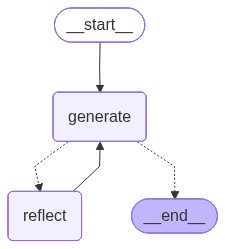

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Generate an essay on the topicality of The Little Prince and its message in modern life"
        )
    ],
):
    ChatPromptTemplate.from_messages(event).pretty_print()
    print(list(event.values())[0].content)
    print("---")

================================ Human Message =================================

generate
## The Enduring Wisdom of a Little Prince: Relevance in a Modern World

Antoine de Saint-Exupéry's "The Little Prince," a seemingly simple children's story, continues to resonate deeply with readers of all ages in the 21st century. Its enduring topicality stems from its profound exploration of universal themes like love, loss, connection, and the dangers of superficiality, all of which remain intensely relevant in our increasingly complex and often disconnected modern world. The prince's journey across the cosmos offers a poignant commentary on the values we prioritize, urging us to reconsider what truly matters in life.

One of the most striking aspects of the story's modern relevance lies in its critique of adult preoccupations. The inhabitants of the asteroids the Little Prince visits – the king obsessed with authority, the conceited man craving admiration, the businessman counting stars, and 

In [ ]:
list(event.values())[0].content

'Thank you so much! I really appreciate your help and expertise.\n'

## Conclusion

Now that you've applied reflection to an LLM agent, I'll note one thing: self-reflection is inherently cyclic: it is much more effective if the reflection step has additional context or feedback (from tool observations, checks, etc.). If, like in the scenario above, the reflection step simply prompts the LLM to reflect on its output, it can still benefit the output quality (since the LLM then has multiple "shots" at getting a good output), but it's less guaranteed.
